- 출처 : - https://www.kaggle.com/vincee/intel-image-classification-cnn-keras
# Intel Image Classification (CNN - Keras)

In this notebook, I will try the process of implementing CNN with Keras in order to classify images.
1. Firstly, we'll import usefull packages.
1. Then, we'll load the data, before visualize and preprocess it.
1. We'll try a simple CNN model and then we will evaluate its performances.
1. We will then use pre trained model to address this challenge aswell.

# 대회 소개
- https://www.kaggle.com/puneet6060/intel-image-classification
- **Context**
  - This is image data of Natural Scenes around the world.

- **Content**
  - This Data contains around 25k images of size 150x150 distributed under 6 categories.
  ```
    {'buildings' -> 0,
    'forest' -> 1,
    'glacier' -> 2,
    'mountain' -> 3,
    'sea' -> 4,
    'street' -> 5 }
    ```

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
class_names_label

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [4]:
def load_data():
    datasets = ['./data/seg_train/seg_train', './data/seg_test/seg_test']
    output = []
    for dataset in datasets:
        images = []
        labels = []
        print(f"Loading {dataset}")
        for folder in os.listdir(dataset): #listdir - 디렉토리 리스트
            label = class_names_label[folder]
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # Open and resize the img
                image = cv2.imread(img_path)
                #COLOR_BGR2RGB : BGR 이미지를 RGB로 변환하기
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                #append
                images.append(image)
                labels.append(label)
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))
    return output

In [5]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ./data/seg_train/seg_train


100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:04<00:00, 492.98it/s]


Loading ./data/seg_test/seg_test


100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 581.16it/s]


# Let's explore the dataset
We can ask ourselves:
* How many training and testing examples do we have ?
* What is the size of the images ?
* What is the proportion of each observed category ?

In [6]:
print("Number of training examples : {}".format(train_labels.shape[0]))
print("Number of testing examples : {}".format(test_labels.shape[0]))
print("Each image is of size : {}".format(IMAGE_SIZE))

Number of training examples : 14034
Number of testing examples : 3000
Each image is of size : (150, 150)


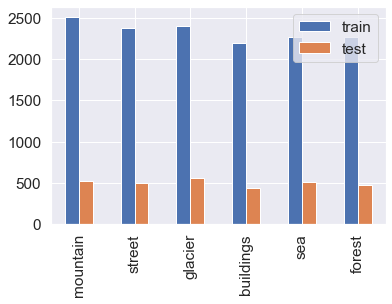

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts, 'test': test_counts}, index=class_names).plot.bar()
plt.show()

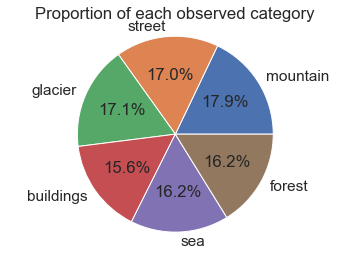

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Good practice: scale the data

In [9]:
#각 픽셀 값들을 255로 나눠준다. -> 0~1 사이의 값으로 바뀐다.
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualize the data
We can display a random image from the training set.

In [10]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(f"Image #{index} {class_names[labels[index]]}")

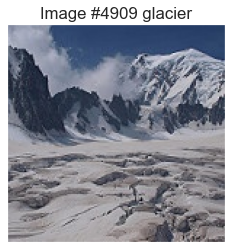

In [11]:
display_random_image(class_names, train_images, train_labels)

In [12]:
def display_25images(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("25 images", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

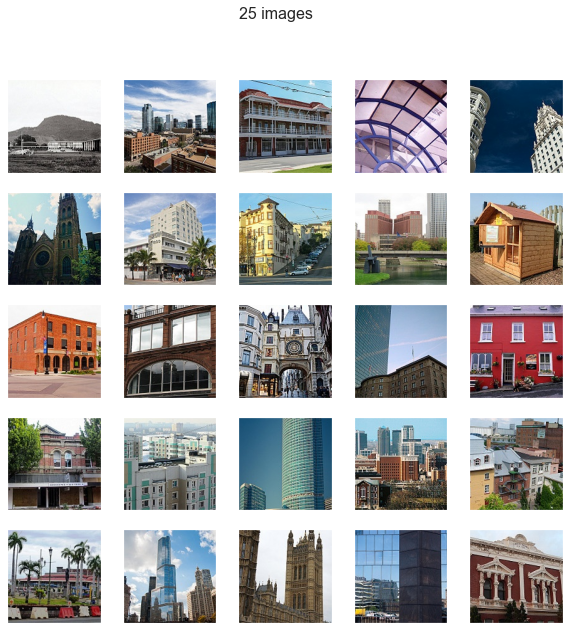

In [13]:
display_25images(class_names, train_images, train_labels)

# Beginner: Simple Model Creation

Steps are:
1. Build the model,
1. Compile the model,
1. Train / fit the data to the model,
1. Evaluate the model on the testing set,
1. Carry out an error analysis of our model.

We can build an easy model composed of different layers such as:
* Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
* MaxPooling2D: The images get half sized.
* Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
* Relu  : given a value x, returns max(x, 0).
* Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Then, we can compile it with some parameters such as:
* **Optimizer**: adam = RMSProp + Momentum.
What is Momentum and RMSProp ?
* Momentum = takes into account past gradient to have a better update.
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [15]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 135s 2s/step - loss: 1.0154 - accuracy: 0.6178 - val_loss: 13.4599 - val_accuracy: 0.0552
Epoch 2/20
88/88 [==============================] - 125s 1s/step - loss: 0.6447 - accuracy: 0.7649 - val_loss: 14.2414 - val_accuracy: 0.0620
Epoch 3/20
88/88 [==============================] - 131s 1s/step - loss: 0.5422 - accuracy: 0.7964 - val_loss: 17.3325 - val_accuracy: 0.1058
Epoch 4/20
88/88 [==============================] - 142s 2s/step - loss: 0.4142 - accuracy: 0.8548 - val_loss: 19.3671 - val_accuracy: 0.1069
Epoch 5/20
88/88 [==============================] - 141s 2s/step - loss: 0.3133 - accuracy: 0.8961 - val_loss: 20.7699 - val_accuracy: 0.1065
Epoch 6/20
88/88 [==============================] - 137s 2s/step - loss: 0.2340 - accuracy: 0.9230 - val_loss: 24.7502 - val_accuracy: 0.1076
Epoch 7/20
88/88 [==============================] - 144s 2s/step - loss: 0.1649 - accuracy: 0.9483 - val_loss: 25.7605 - val_accuracy: 0.0983
Epoch 

KeyboardInterrupt: 

In [17]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_accuracy vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [18]:
plot_accuracy_loss(history)

NameError: name 'history' is not defined

In [19]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 8s 80ms/step - loss: 7.8492 - accuracy: 0.6640


# Feature extraction with VGG ImageNet
- 정확도 향상을 위해 이미 학습된 모델인 VGG 사용

In [20]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 2s 0us/step


In [22]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

KeyboardInterrupt: 

## Training on top of VGG

Let's train a simple one-layer Neural Network on the features extracted from VGG.

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

In [ ]:
plot_accuracy_loss(history)

In [ ]:
test_loss = model2.evaluate(test_features, test_labels)

# Ensemble Neural Networks

In [ ]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

We define n_estimators Neural Networks. 

Each Neural Network will be trained on random subsets of the training dataset. Each subset contains max_samples samples.

In [ ]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [ ]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

We aggregate each model individual predictions to form a final prediction.

In [ ]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

We should improve our result as we have a lower variance.

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))